#### <span style="color:#AD07FF"> In this notebook you can see data cleaning, visualization, hypothesis testing,  <br> adding new features and preparing data so that we can run a model.

# <span style="color:#FF7B07"><div align="center">**Table Of Contents**
[<span style="color:#FF7B07">**1. Introduction**](#1)<br>
[<span style="color:#FF7B07">**2. Import Libraries and Load Data**](#2)<br>
[<span style="color:#FF7B07">**3. Data Analysis**](#3)<br>
[<span style="color:#FF7B07">**4. Create Features**](#4)<br> 
[<span style="color:#FF7B07">**5. Data Cleaning**](#5)<br>
[<span style="color:#FF7B07">**6. Data Preparation**](#6)<br> 

# <span style="color:#FF7B07"><div align="center">**Introduction** <a  name="1"></a>

Nowadays, a healthy lifestyle is becoming a valuable characteristic of a modern society. <br>
More and more people try to enhance their health by doing regularly different sports and put emphasis on their food habits. <br>
In order to satisfy the specific needs of every individual, conclusions gained out of the users’ data are from high importance. <br>
Companies such as MyFitnessPal operate in the lucrative business field of health data. <br>
The healthcare industry is booming, especially when it comes to the analysis of health-related data. <br>
This report will show how the analysis of data will improve the life of the users, <br>
but also highlight the potential for companies active in the business. <br>
#### <span style="color:#FF7B07">  **Source** https://www.kaggle.com/vetrirah/customer?select=Train.csv

# <span style="color:#FF7B07"><div align="center">**Import Libraries and Load Data** <a  name="2"></a>

In [1]:
from datetime import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn import preprocessing
from bs4 import BeautifulSoup as bs
import os

%matplotlib inline

In [2]:
# The data is large and this command will help us to see the whole result 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
data = pd.read_csv('../my_fitness_pal/data/myFitnessPal_parsed.csv')

In [4]:
with open('foods.json') as json_file:
     food_names = json.load(json_file)

In [5]:
with open('../my_fitness_pal/data/FoodWithAdditionalNutritionalInformation.json') as json_file:
    foods = json.load(json_file)

foods_and_groups = pd.read_excel('../my_fitness_pal/data/MyFoodData-Nutrition-Facts-SpreadSheet-Release-1-4.xlsx')

foods_and_groups = foods_and_groups.drop_duplicates(['name', 'Food Group'])[['name', 'Food Group']]
foods_and_groups.columns = ['Food', 'Food Group']

# <span style="color:#FF7B07"><div align="center">**Data Analysis** <a  name="3"></a>

#### <span style="color:#FF7B07">Let us first review the general information of the data 

In [6]:
print(f'\n Data shape - {data.shape} ')
print(f' Unique users - {data["user_id"].nunique()} \n')
data.head(3)



 Data shape - (587186, 16) 
 Unique users - 9896 



,user_id,date,sequence,food_ids,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar
0,1,2014-09-15,1,"[1, 2, 3, 4, 4]",2430,96,37.0,50.0,855.0,63.0,1572.0,196.0,52.0,79.0,2300.0,59.0
1,1,2014-09-16,1,"[5, 1, 2, 3, 6, 7]",1862,158,54.0,114.0,2215.0,100.0,1832.0,229.0,61.0,92.0,2300.0,69.0
2,1,2014-09-17,1,"[1, 2, 3, 6, 8, 9, 10]",2251,187,60.0,98.0,1765.0,105.0,1685.0,210.0,56.0,85.0,2300.0,63.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587186 entries, 0 to 587185
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         587186 non-null  int64  
 1   date            587186 non-null  object 
 2   sequence        587186 non-null  int64  
 3   food_ids        587186 non-null  object 
 4   total_calories  587186 non-null  int64  
 5   total_carbs     587186 non-null  int64  
 6   total_fat       586309 non-null  float64
 7   total_protein   586309 non-null  float64
 8   total_sodium    585881 non-null  float64
 9   total_sugar     585879 non-null  float64
 10  goal_calories   585264 non-null  float64
 11  goal_carbs      585261 non-null  float64
 12  goal_fat        559873 non-null  float64
 13  goal_protein    559868 non-null  float64
 14  goal_sodium     519466 non-null  float64
 15  goal_sugar      519196 non-null  float64
dtypes: float64(10), int64(4), object(2)
memory usage: 71.7+ 

#### <span style="color:#00CC00"> As you can see most of the feature's type is number so we don't need to convert them <br>  except "date" and "food_ids" which needs to converted.

In [8]:
data.describe()

,user_id,sequence,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar
count,587186.000000,587186.000000,5.871860e+05,587186.000000,586309.000000,586309.000000,585881.000000,585879.000000,585264.000000,585261.000000,559873.000000,559868.000000,519466.000000,519196.000000
mean,4946.928031,4.004532,1.421923e+03,153.679057,71.235077,93.821524,1157.984207,407.563147,1613.422573,194.222680,90.101536,157.212782,1446.919333,411.366736
std,2844.719822,1.341577,2.284502e+03,355.777029,277.018504,289.062514,2049.176072,907.108966,722.874981,352.425203,240.765991,390.169810,1166.553691,886.227384
min,1.000000,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2513.000000,3.000000,1.038000e+03,76.000000,29.000000,40.000000,30.000000,22.000000,1314.000000,122.000000,46.000000,70.000000,56.000000,45.000000
50%,4928.000000,4.000000,1.403000e+03,135.000000,49.000000,66.000000,690.000000,51.000000,1630.000000,178.000000,58.000000,96.000000,2300.000000,64.000000
75%,7427.000000,5.000000,1.766000e+03,191.000000,72.000000,98.000000,1982.000000,139.000000,1991.000000,227.000000,77.000000,135.000000,2300.000000,100.000000
max,9897.000000,6.000000,1.200800e+06,210865.000000,132088.000000,114949.000000,960000.000000,168015.000000,26068.000000,154417.000000,38128.000000,102945.000000,23009.000000,35055.000000


#### <span style="color:#00CC00"> At first glance we would probably see that data needs to be normalized and maybe we have some outliers too

#### <span style="color:#FF7B07"> As we know we have a different number of records for each user in the data 

In [9]:
print(f'user_id 1 has {len(data[data["user_id"]==1])} records')
print(f'user_id 2 has {len(data[data["user_id"]==2])} records')

user_id 1 has 173 records
user_id 2 has 60 records


#### <span style="color:#FF7B07"> User may also have missed information between the first and final days of the record

In [10]:
data[data["user_id"]==7].head(2)

,user_id,date,sequence,food_ids,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar
561,7,2014-10-06,1,"[980, 981]",360,45,14.0,15.0,2.0,5.0,1400.0,140.0,31.0,140.0,25.0,102.0
562,7,2014-10-15,1,[982],140,2,9.0,12.0,0.0,1.0,1400.0,140.0,31.0,140.0,25.0,102.0


#### <span style="color:#00CC00"> As we can see, User whose ID is 7, made the first record in 2014-10-06 and the second in 2014-10-15. <br> We will need to reflect this information as new feature

#### <span style="color:#FF7B07"> Check for null values in the data

In [11]:
null_df = pd.DataFrame(data.isna().sum())
null_df.columns = ["Null Frequency"]
null_df.T

,user_id,date,sequence,food_ids,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar
Null Frequency,0,0,0,0,0,0,877,877,1305,1307,1922,1925,27313,27318,67720,67990


#### <span style="color:#00CC00"> As we saw there are 10 columns which have sometimes null values <br> User can have a maximum of 10 columns with null value <br> So I think we should throw away a user who has 4 or more Null values, <br> Because otherwise it would turn out that we have filled more than 25 percent of the user information

In [12]:
print('Users which have null in more than 3 columns : ',(len(data.loc[data.isnull().sum(axis=1)>3])/len(data))*100,'%')
nullColumns = data.loc[data.isnull().sum(axis=1)>3].index
nullColumns = pd.DataFrame(nullColumns,columns={'index'})

Users which have null in more than 3 columns :  4.6515073588266755 %


#### <span style="color:#00CC00"> It seems that the number of such people is about 4.6 percent. <br> Due to the fact that the data is not so little and at the same time filling 4 null feature is not so accurate we can throw them 

#### <span style="color:#FF7B07"> There can still be a problem with the values and such a situation is when the goal calories are 0 <br>and the mentioned situation does not make sense <br> because the main purpose of the app is to select a goal and get closer to it.

In [13]:
print('Users which have zero in goal_calories : ',(len(data[data['goal_calories']==0])/len(data))*100,'%')

Users which have zero in goal_calories :  0.11767991743672362 %


#### <span style="color:#00CC00"> It seems that the number of such people is about 0.1 percent. So we can throw them away 

In [14]:
def createPlot(data, col:str, ttext:str, xtext:str, ytext:str) ->None:
    """
    this function creates histogram and boxplot by pyplot library and also count skewness
    
    Arguments:
    data -- pandas dataframe
    col -- column name which we want to plot
    ttext -- string which we want to write on top of the graph
    xtext -- string which we want to write on x axis
    ytext -- string which we want to write on y axis
    
    Returns:
    None
    """
    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Histogram(x=data[col],marker_color='#6a6fff'),row=1,col=1)
    fig.add_trace(go.Box(x=data[col]),row=1,col=2)
    
    fig.update_layout(
        title_text=ttext,
        xaxis_title_text=xtext,
        yaxis_title_text=ytext, 
        bargap=0.05, 
        template = 'plotly_dark',
        width=900, height=600
    )
    fig.add_annotation(dict(font=dict(color='yellow',size=15),
                                        x=0.35,
                                        y=1.1,
                                        showarrow=False,
                                        text="Skewness = "+str(data[col].skew()),
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
    
    fig.show()
#createPlot(data,"goal_calories","Time Distribution","Time (days)","count")

In [15]:
# groups = ['Low','Medium','High']
# dfForPlot = df.copy();
# def get_categories(x):
#     if x < q1:
#         return groups[0]
#     elif x < q3:
#         return groups[1]
#     else:
#         return groups[2]    

# for col in numVariable:
#     q1 = df[col].quantile(q=0.25)
#     q3 = df[col].quantile(q=0.75)
#     dfForPlot[col] = df[col].apply(get_categories)

#### <span style="color:#FF7B07"> There are many spreaded Hypotheses about diet, healthy lifestyle and also about habits too. Now let's check their validity with our data

#### <span style="color:#FF7B07">  1. People more likely start diet and healthy lifestyle on mondays

In [16]:
daysCount=[0,0,0,0,0,0,0]
for ID in data['user_id'].unique():
    date = data[data["user_id"]==ID].head(1)['date'].values[0]
    d=datetime.strptime(str(date), "%Y-%m-%d")
    daysCount[d.weekday()]+=1

<AxesSubplot:xlabel='days', ylabel='quantities'>

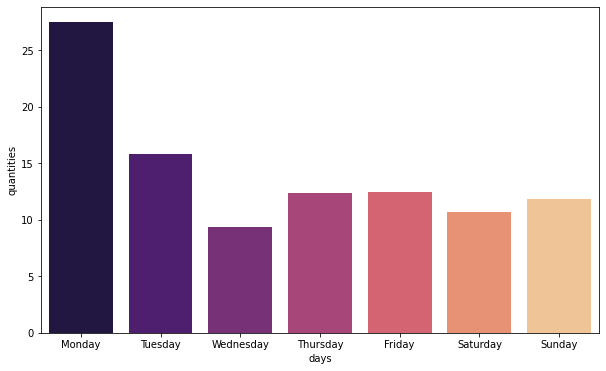

In [17]:
res = np.dot([i / np.sum(daysCount) for i in daysCount],100)
fig, ax = plt.subplots(figsize=(10,6))
df=pd.DataFrame({'days':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],'quantities': res})
sns.barplot(x='days',y='quantities',data=df,palette='magma',ax=ax)

#### <span style="color:#00CC00"> The results show that hypothesis were right: <br>  people more likely start diet on mondays and the graph also proves that wednesday is really lazy day to start something. 

#### <span style="color:#FF7B07">  2. People frequently cheat diet on weekends

In [18]:
daysCount=[0,0,0,0,0,0,0]
daysLogged=[0,0,0,0,0,0,0]
for i,row in data.iterrows():
    date = row['date']
    goal_calories=row['goal_calories']
    total_calories=row['total_calories']
    if total_calories > (goal_calories+goal_calories*15) :  # actually total_calories more than approx. 5 hamburgers  😂 
        d=datetime.strptime(str(date), "%Y-%m-%d")
        daysCount[d.weekday()]+=1
    daysLogged[d.weekday()]+=1

In [19]:
res = [i / j for i, j in zip(daysCount,daysLogged)]
res =np.dot( [i / np.sum(res) for i in res],100)

<AxesSubplot:xlabel='days', ylabel='quantities'>

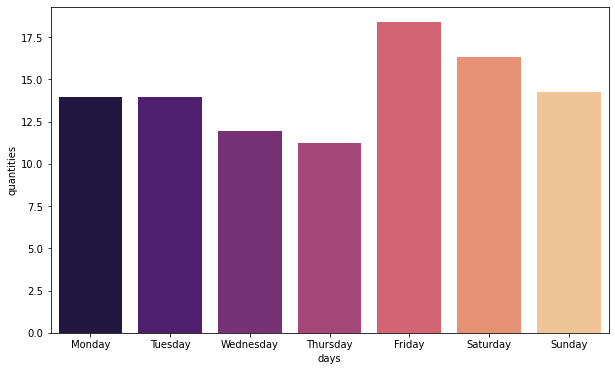

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
df=pd.DataFrame({'days':['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],'quantities': res})
sns.barplot(x='days',y='quantities',data=df,palette='magma',ax=ax)

#### <span style="color:#00CC00"> Looks like people use to cheat on fridays and saturdays more, they took much more calories on these days. Our hypothesis partially justified

#### <span style="color:#FF7B07">  3. 77 percent of users never use an app again 72 hours after installing

In [21]:
apps_log=pd.DataFrame()
apps_log["people"] = data["user_id"].value_counts()
apps_log["days_used_app"] = apps_log["people"].apply(lambda x: len(apps_log[apps_log["people"]==x]))

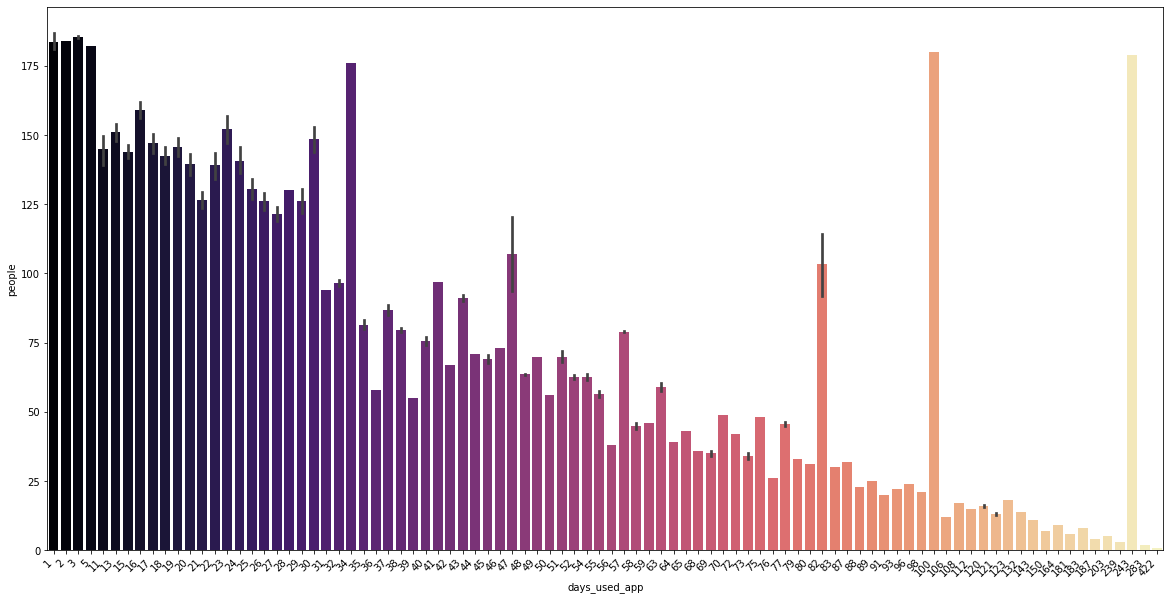

In [22]:
fig, ax = plt.subplots(figsize=(20,10))
plott=sns.barplot(x='days_used_app',y='people',data=apps_log,palette='magma',ax=ax)
plott=plott.set_xticklabels(plott.get_xticklabels(),rotation=45,ha="right")
# pltt.yticks(rotation='horizontal')

#### <span style="color:#00CC00"> Hypothesis is partly correct, app's usage reduces exponentially but It takes users almost 1 month to surrender. Maybe it's not the surrender, maybe it's the period they reach dreamy weight

#### <span style="color:#FF7B07"> Now look at the nutrients individually as taking extra nutrients can be dangerous For example taking too much sugar can cause diabetes <br> Let's draw total and goal nutrients together and see how many percentage is under or above risk <br> Based on this information we can tell the customer to reduce consumption or increase it depending on whether he is at risk or not. 

In [23]:
def plot_nutrient(df,nutrient_name,goal_nutrient_name,thr1,thr2):
    """
    This function creates 3 plots based on thresholds
    
    Arguments:
    df -- pandas dataframe
    nutrient_name -- column name which we want to plot
    goal_nutrient_name -- column name which we want to plot
    thr1 -- threshold on the values below which we draw the first drawing   
    thr2 -- threshold on the values above which we draw the third drawing
    
    Returns:
    None
    """
    avg = df.groupby(['user_id']).apply(lambda x: x[nutrient_name].sum()/len(x)).reset_index()
    goal = df.groupby(['user_id']).apply(lambda x: x[goal_nutrient_name].sum()/len(x)).reset_index()
    avg.columns = ["user_id", "avg_nut"]
    goal.columns = ["user_id", "goal_avg_nut"]

    fig, ax =plt.subplots(1,3,figsize=(17,7))
    _max = max(df[nutrient_name].max(),df[goal_nutrient_name].max())
    ax[0].hist(avg[avg['avg_nut']<thr1]['avg_nut'], range=[0,thr1], color='Red', fc='none', lw=2, histtype='step')
    ax[0].hist(goal[goal['goal_avg_nut']<thr1]['goal_avg_nut'], range=[0,thr1], color='Green', fc='none', lw=2, histtype='step')
    ax[0].legend(('Total', 'Goal'), loc="upper right")
    ax[1].hist(avg['avg_nut'], range=[thr1,thr2], color='Red',fc='none', lw=2, histtype='step')
    ax[1].hist(goal['goal_avg_nut'], range = [thr1,thr2], color='Green', fc='none', lw=2, histtype='step')
    ax[1].legend(('Total', 'Goal'), loc="upper right")
    ax[2].hist(avg[avg['avg_nut']>thr2]['avg_nut'], range=[thr2,_max], color='Red', fc='none', lw=2, histtype='step')
    ax[2].hist(goal[goal['goal_avg_nut']>thr2]['goal_avg_nut'], range=[thr2,_max], color='Green', fc='none', lw=2, histtype='step')
    ax[2].legend(('Total', 'Goal'),loc="upper right")
    
    under_minimum = len(avg[avg['avg_nut'] < thr1])
    above_minimum = len(avg[avg['avg_nut'] > thr2])
    total = avg.user_id.nunique()

    print(f'\nlower risk group: {100*under_minimum/total} %')
    print(f'above risk group: {100*above_minimum/total} %')
    print(f'not   risk group: {100*(1-(under_minimum+above_minimum)/total)} %\n')

In [24]:
user_tenure = data['user_id'].value_counts().to_frame().reset_index()
user_tenure.columns = ['user_id', 'Amount']

top_users = pd.merge(data, user_tenure.head(1000), on='user_id', how='inner')


lower risk group: 42.0 %
above risk group: 23.1 %
not   risk group: 34.9 %



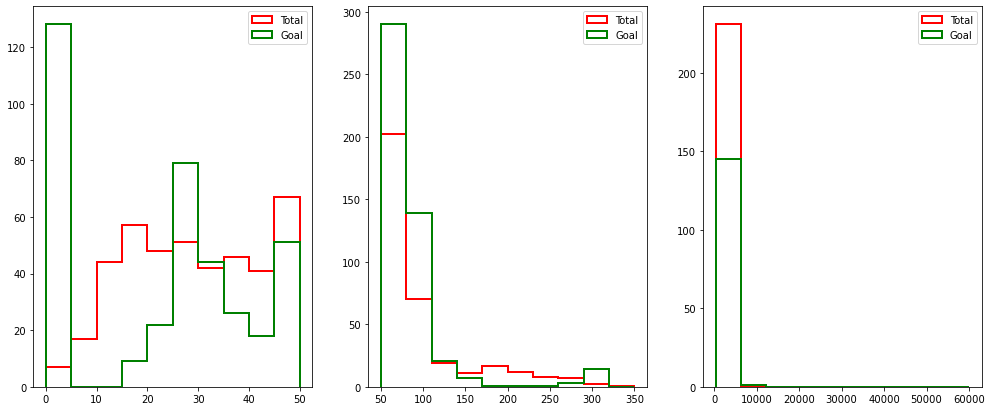

In [25]:
plot_nutrient(top_users,"total_sugar","goal_sugar",50,350)


lower risk group: 5.4 %
above risk group: 2.1 %
not   risk group: 92.5 %



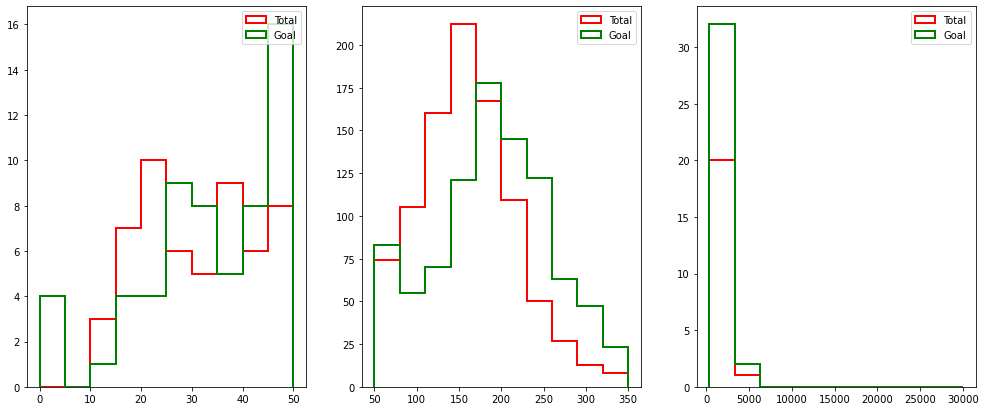

In [26]:
plot_nutrient(top_users,"total_carbs","goal_carbs",50,350)

#### <span style="color:#FF7B07"> Let's see what food they eat most often in month. <br> This information can be used by markets to determine how many products they should receive per month 

In [27]:
def add_elem_dict(all_names,lst):
    for food_id in lst[1:-1].split(","):
        food_id = food_id.replace(' ','')
        all_names[food_id] = all_names.get(food_id,0)+1
        
def get_top_food_ids(df,top_numbers):
    all_names = {}
    df["food_ids"].apply(lambda lst: add_elem_dict(all_names,lst))
    top_food_ids = list(sorted(all_names.items(), key=lambda item: item[1]))
    top_food_ids = [key for key,value in top_food_ids]
    top_food_ids.reverse()
    return top_food_ids[:10]

In [28]:
data["month"] = data["date"].apply(lambda x: x[5:7])
max_food_in_month = data.groupby(['month']).apply(lambda x: get_top_food_ids(x,10))
del data["month"]

top_food_dataframe = pd.DataFrame(max_food_in_month)
top_food_dataframe = top_food_dataframe.apply(lambda x: x[0], axis = 1, result_type ='expand').reset_index()
top_food_dataframe.columns = ["month","meal_1","meal_2","meal_3","meal_4","meal_5","meal_6","meal_7","meal_8","meal_9","meal_10"]

In [29]:
for col in top_food_dataframe.columns:
    top_food_dataframe[col] = top_food_dataframe[col].apply(lambda food_id: food_names[str(int(food_id))])

In [30]:
top_food_dataframe

,month,meal_1,meal_2,meal_3,meal_4,meal_5,meal_6,meal_7,meal_8,meal_9,meal_10
0,my - McDonalds Espresso Pronto® Flat White,Coffee - Brewed from grounds,Quick Added Calories,Bananas - Raw,Spinach - Raw,Butter - Salted,Apples - Raw,Strawberries - Raw,Blueberries - Raw,Cucumber - With peel,Carrots - Raw
1,Uncle Tobys Australia - Vita Brits,Coffee - Brewed from grounds,Quick Added Calories,Bananas - Raw,Spinach - Raw,Strawberries - Raw,Blueberries - Raw,Butter - Salted,Apples - Raw,Cucumber - With peel,Carrots - Raw
2,Pauls - Smarter White Milk,Coffee - Brewed from grounds,Quick Added Calories,Bananas - Raw,Strawberries - Raw,Spinach - Raw,Butter - Salted,Apples - Raw,Chicken - Breast,Cucumber - With peel,Blueberries - Raw
3,Quick Added Calories,Coffee - Brewed from grounds,Quick Added Calories,Strawberries - Raw,Bananas - Raw,Apples - Raw,Spinach - Raw,Chicken - Breast,Carrots - Raw,Blueberries - Raw,Butter - Salted
4,Sainsbury's - Italian - Spaghetti Carbonara,Coffee - Brewed from grounds,Quick Added Calories,Bananas - Raw,Spinach - Raw,Cucumber - With peel,Apples - Raw,Oil - Olive,Butter - Salted,Carrots - Raw,Strawberries - Raw
5,Carluccio's - Affogato (Espresso),Coffee - Brewed from grounds,Quick Added Calories,Bananas - Raw,Apples - Raw,Spinach - Raw,Oil - Olive,Butter - Salted,Cucumber - With peel,Carrots - Raw,Peppers - Sweet
6,Steak - Eye Fillet,Coffee - Brewed from grounds,Quick Added Calories,Bananas - Raw,Apples - Raw,Spinach - Raw,Butter - Salted,Carrots - Raw,Cucumber - With peel,Oil - Olive,Chicken - Breast
7,Tasti - Salted Caramel Protein Bar,Coffee - Brewed from grounds,Quick Added Calories,Bananas - Raw,Spinach - Raw,Apples - Raw,Butter - Salted,Cucumber - With peel,Carrots - Raw,Eggs - Fried (whole egg),Chicken - Breast


#### <span style="color:#00CC00"> As we can see, Strawberries - Raw is in the top products after January <br> and every month it increases its popularity until May and then the amount of its use decreases again which is logical 

# <span style="color:#FF7B07"><div align="center">**Create Features** <a  name="4"></a>

In [31]:
data.head(3)

,user_id,date,sequence,food_ids,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar
0,1,2014-09-15,1,"[1, 2, 3, 4, 4]",2430,96,37.0,50.0,855.0,63.0,1572.0,196.0,52.0,79.0,2300.0,59.0
1,1,2014-09-16,1,"[5, 1, 2, 3, 6, 7]",1862,158,54.0,114.0,2215.0,100.0,1832.0,229.0,61.0,92.0,2300.0,69.0
2,1,2014-09-17,1,"[1, 2, 3, 6, 8, 9, 10]",2251,187,60.0,98.0,1765.0,105.0,1685.0,210.0,56.0,85.0,2300.0,63.0


#### <span style="color:#00CC00"> As we see one feature which needs to be remaked is food_ids <br> So, we will extract most of the information from the given feature and create a new one <br> so that we can lose as few information as possible.<br> Firstly, we'll create a new attribute based on the size of food_ids . 

In [32]:
data['foods_len'] = data["food_ids"].apply(lambda x: len(x[1:-1].split(',')))

In [33]:
# createPlot(data,"foods_len","Foods len Dist","Foods length","count")

✔️ Foods_len is right skewed (0.8). <br>
❌ There are a few outliers in the distribution. <br>
✔️ Most of the applicant's foods_len is near 10 <br> 
❌ Max number of foods in one day is 62 <br>
✔️ Min number of foods in one day is 1

#### <span style="color:#FF7B07"> For each user we may have several rows. <br> Our goal is to transform the data so that we have one characteristic or one row for each person. <br> So let's take a separate feature of how many records we have for each person. <br> It will also help us to store information and according to the algorithm we can select people who for example have less than 10 records

#### <span style="color:#FF7B07"> To do this,we create temporary dataframe where we will have unique user IDs and the corresponding number of logs<br>  so that we do not want the values to be repeated and data manipulation to become difficult. <br> Finally after we prepare the data we will add it and we will have all the columns together so do not be confused 

In [34]:
# add new feature which shows how many days are logged by each applicants
user_logged_freq = data["user_id"].value_counts()
user_logged_df = pd.DataFrame(data["user_id"].unique(),columns = ['user_id'])
user_logged_df["logged_frequency"] = user_logged_df["user_id"].apply(lambda _id: user_logged_freq[_id])

In [35]:
# createPlot(user_logged_df,"logged_frequency","logged Distribution","logged","count")

✔️ logged frequency is right skewed (0.8). <br>
✔️ There are no outliers in the distribution. <br>
✔️ Most of the logged frequency is near 42 <br> 
✔️ Max number of logs is 187 <br>
❌ Max number of logs is 1

#### <span style="color:#00CC00"> It seems that there are people who have 187 records and also people with 1 record

#### <span style="color:#FF7B07"> As we saw, users may have missed data between start and end date, <br> so let's do a separate feature to show that <br> This will help us retain as much information as possible about our customers

In [36]:
# this function counts whole days between start and end date and calculates missed days for new feature
def days_missed(d1, d2,loggedDays):
    d1 = datetime.strptime(str(d1), "%Y-%m-%d")
    d2 = datetime.strptime(str(d2), "%Y-%m-%d")
    return abs(abs((d2 - d1).days)-loggedDays)

In [37]:
# this function calls days_missed regarding last and first records
def get_missed_days(df,userID,logged_frequency):
    tail = df[df["user_id"]==userID].tail(1)['date'].values[0]
    head = df[df["user_id"]==userID].head(1)['date'].values[0]
    return days_missed(tail,head,logged_frequency)   

In [38]:
# add new feature based on how many days are missed for each user
user_logged_df['days_missed'] = user_logged_df[['user_id','logged_frequency']].apply(lambda x: get_missed_days(data,x.user_id,x.logged_frequency),axis=1)

In [39]:
# createPlot(user_logged_df,"days_missed","Missing days Distribution","Missing days","count")

✔️ Missing days is right skewed (0.4). <br>
✔️ There are no outliers in the distribution. <br>
❌ Most of the Missing frequency is near 48 <br> 
❌ Max number of logs is 174 <br>
✔️ Max number of logs is 1

#### <span style="color:#FF7B07"> Since the data relates to nutrition, health and exercise, <br>we need to have a separate variable for each row <br> that shows user's nutritions ratio satisfies the known dependence. If it's in accepted norm, we call it healthy distributed.

In [40]:
def getHealtyDistributedValues(value,lower,upper):
    if(value <= lower):
        return lower-value # the difference person lacked 
    if(value >= upper):
        return value-upper # the difference person exceed 
    return 0 # method returns 0 for the values in range

In [41]:
# There is known that for healthy eating, daily carbs should be between 45-65% out of callories, fats between 10-35% and proteins 20-35%
# So this method counts daily norm distribution of person
# 0 for the people in persmissible range
# max value may be 1.3 (when person only took fats)

def healthyDistributed(carbs,fat,protein):
    totalCalories = fat*9+ carbs*4 + protein*4 # convert to calories (1g fat = 9 calories and etc..) and sum
    sum =  getHealtyDistributedValues ( carbs*4 / (totalCalories+0.00000001),0.45,0.65)
    sum += getHealtyDistributedValues ( protein*4 / (totalCalories+0.00000001),0.2,0.35)
    sum += getHealtyDistributedValues ( fat*9 / (totalCalories+0.00000001),0.1,0.35)
    return sum

In [42]:
data['healtyDistrib'] = data[['total_carbs','total_fat','total_protein']].apply(lambda x: healthyDistributed(x.total_carbs,x.total_fat,x.total_protein),axis=1)

In [43]:
# createPlot(data,"healtyDistrib","healthy Distribution","value","count")

✔️ Healthy distribution is right skewed (0.4). <br>
❌ There are many outliers in the distribution. <br>
✔️ Median is near a range of 0.1 <br> 
❌ Max number of values is 1.3 <br>
✔️ Min number of values is 0

#### <span style="color:#FF7B07"> One of the algorithms which we'll implement is to predict whether each user approaches the goal in the future or not <br>so we need a variable that describes this. 

In [44]:
# this function gets all nutrition values with goals and checks if calories difference is less than percentage of goals
# TODO:
def check_bounds(total_calories, total_carbs, total_fat, total_protein, total_sodium, total_sugar, 
               goal_calories, goal_carbs, goal_fat, goal_protein, goal_sodium, goal_sugar,percent):
    
    return (abs(goal_calories - total_calories) < goal_calories * percent / 100)

In [45]:
# this function checks last days for user and counts number of days when his nutrient was in goal range
def reach_goal(df,user_id,num_days):
    allowed_difference_percentage = 15
    tails = df[df["user_id"]==user_id].tail(num_days)
    tails["reach_goal"] = tails.apply(lambda row: check_bounds(*(row.values[4:16]),allowed_difference_percentage),axis=1)
    return tails["reach_goal"].sum()

In [46]:
# create new feature which shows if user reaches goals in last days 
# and return 1 if the number of days when user reached goal is greater than threshold else 0
# TODO:

number_of_last_days = 5
threshold = 2
user_logged_df["reach_goal"] = user_logged_df['user_id'].apply(lambda x: reach_goal(data,x,number_of_last_days))
user_logged_df["reach_goal"] = user_logged_df["reach_goal"].apply(lambda x: 1 if x>=threshold else 0)

In [47]:
# f, ax  = plt.subplots(1,2,figsize = (18,6))
# sns.countplot(x=user_logged_df['reach_goal'],ax=ax[0],palette = 'bright',alpha=0.7)

# count = user_logged_df['reach_goal'].value_counts(normalize=True)
# count.plot.pie(autopct="%.2f%%",explode = [0,0.2],ax=ax[1])
# plt.show()

#### <span style="color:#00CC00"> As we see it, the reach_goal is twice as low, so we will need to treat the imbalance. which we can with two ways: <br> 1. Preproccess data <br> 2. Come up with appropriate metric

#### <span style="color:#FF7B07"> Each user has its goal and real received nutrient columns <br> so it is important to know the deviation between them and bring them out as a separate feature

In [48]:
data["calories_diff"] = data["goal_calories"]-data["total_calories"]
data["carbs_diff"] = data["goal_carbs"]-data["total_carbs"]
data["fat_diff"] = data["goal_fat"]-data["total_fat"]
data["protein_diff"] = data["goal_protein"]-data["total_protein"]
data["sodium_diff"] = data["goal_sodium"]-data["total_sodium"]
data["sugar_diff"] = data["goal_sugar"]-data["total_sugar"]

In [49]:
pd.DataFrame([[col,data[col].max()] for col in data.columns[-6:]], columns = ['col','maximum difference'])

,col,maximum difference
0,calories_diff,24505.0
1,carbs_diff,154161.0
2,fat_diff,38112.0
3,protein_diff,102921.0
4,sodium_diff,22433.0
5,sugar_diff,34997.0


In [50]:
foods_and_groups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14164 entries, 0 to 14163
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Food        14164 non-null  object
 1   Food Group  14036 non-null  object
dtypes: object(2)
memory usage: 332.0+ KB


In [51]:
cols = ['Food', 'Carbs', 'Dietary Fiber', 'Sugar', 'Fat', 'Saturated', 'Polyunsaturated',
        'Monounsaturated', 'Trans','Protein', 'Sodium', 'Potassium', 'Cholesterol',
        'Vitamin A', 'Vitamin C', 'Calcium', 'Iron']

units = [{'Carbs': 'g'},
         {'Dietary Fiber': 'g'},
         {'Sugar': 'g'},
         {'Fat': 'g'},
         {'Saturated': 'g'},
         {'Polyunsaturated': 'g'},
         {'Monounsaturated': 'g'},
         {'Trans': 'g'},
         {'Protein': 'g'},
         {'Sodium': 'mg'},
         {'Potassium': 'mg'},
         {'Cholesterol': 'mg'},
         {'Vitamin A': '%'},
         {'Vitamin C': '%'},
         {'Calcium': '%'},
         {'Iron': '%'}]

In [52]:
detailed_food = pd.DataFrame(columns=cols)

for food in foods:
    values = []
    values.append([list(food.keys())[0]])
    for info in bs(list(food.values())[0]).findAll("div", {"class": "jss123"}):
        try:
            value = int(info.decode_contents().split('<span>')[1].split(' ')[0])
        except:
            value = [None]
        values.append([value])
    try:
        detailed_food = detailed_food.append(pd.DataFrame(data=np.array(values).T, columns=cols), ignore_index=True)
    except:
        pass

detailed_food.head()

<ipython-input-52-ef4774ff6f82>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  detailed_food = detailed_food.append(pd.DataFrame(data=np.array(values).T, columns=cols), ignore_index=True)


,Food,Carbs,Dietary Fiber,Sugar,Fat,Saturated,Polyunsaturated,Monounsaturated,Trans,Protein,Sodium,Potassium,Cholesterol,Vitamin A,Vitamin C,Calcium,Iron
0,Pillsbury Golden Layer Buttermilk Biscuits Art...,41,1,5,13,2,0,0,4,5,1059,0,0,0,0,0,11
1,Pillsbury Cinnamon Rolls With Icing Refrigerat...,53,1,21,11,3,0,0,4,4,780,0,0,0,0,2,10
2,Kraft Foods Shake N Bake Original Recipe Coati...,79,0,0,3,0,0,0,0,6,2182,0,0,0,0,0,0
3,George Weston Bakeries Thomas English Muffins,46,0,0,1,0,0,0,0,8,345,0,0,0,0,18,7
4,Waffles Buttermilk Frozen Ready-To-Heat,41,2,4,9,1,1,4,0,6,621,126,15,26,0,27,33


In [53]:
detailed_food = pd.merge(detailed_food, foods_and_groups, on=['Food'], how='left')
detailed_food['Food Group'].nunique()

22

In [54]:
detailed_food['Food Group'].unique()

array(['Baked Foods', 'Snacks', 'Sweets', 'Vegetables', 'American Indian',
       'Restaurant Foods', 'Beverages', 'Fats and Oils', 'Meats',
       'Dairy and Egg Products', 'Baby Foods', 'Breakfast Cereals',
       'Soups and Sauces', 'Beans and Lentils', 'Fish', 'Fruits', nan,
       'Grains and Pasta', 'Nuts and Seeds', 'Prepared Meals',
       'Fast Foods', 'Spices and Herbs', 'Dairy and Egg Products '],
      dtype=object)

<AxesSubplot:xlabel='count', ylabel='Food Group'>

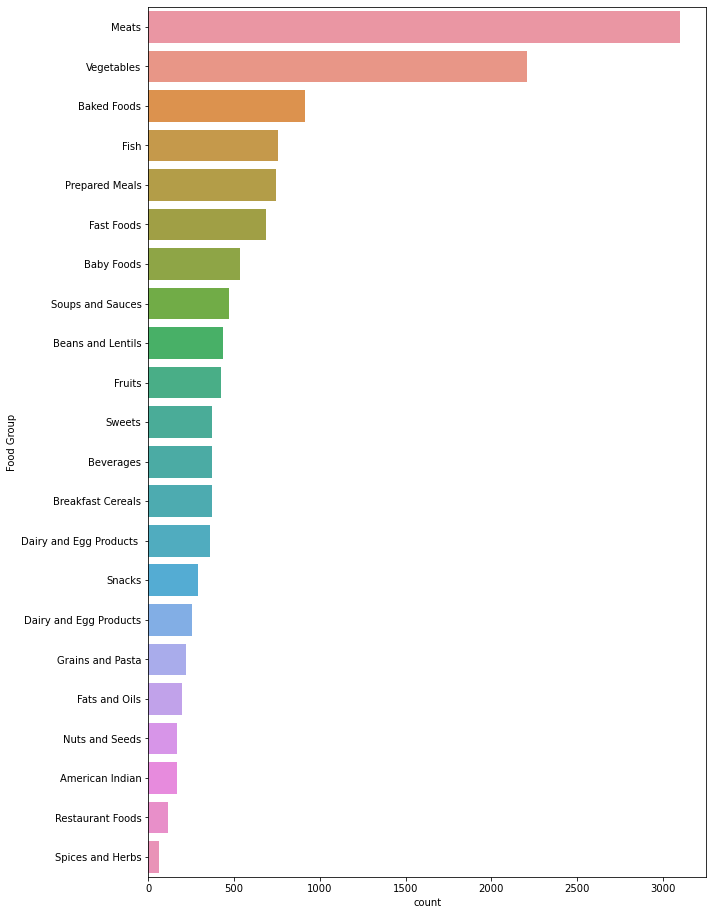

In [55]:
plt.figure(figsize=(10,16))
sns.countplot(y=detailed_food['Food Group'],order=detailed_food['Food Group'].value_counts().index)

In [56]:
len(detailed_food[detailed_food['Food Group'] == 'Spices and Herbs'])

62

In [57]:
data['food_ids'] = data['food_ids'].apply(lambda x: x[1:-1].split(', '))

nutritional_shares = data[['user_id', 'total_calories', 'total_carbs', 'total_fat', 'total_protein', 
                          'total_sodium', 'total_sugar']].groupby(['user_id']).sum().reset_index()

nutritional_shares['total_carbs'] = nutritional_shares['total_carbs']/nutritional_shares['total_calories']
nutritional_shares['total_fat'] = nutritional_shares['total_fat']/nutritional_shares['total_calories']
nutritional_shares['total_protein'] = nutritional_shares['total_protein']/nutritional_shares['total_calories']
nutritional_shares['total_sodium'] = nutritional_shares['total_sodium']/nutritional_shares['total_calories']
nutritional_shares['total_sugar'] = nutritional_shares['total_sugar']/nutritional_shares['total_calories']
nutritional_shares.drop(['total_calories'], axis=1,inplace=True)

nutritional_shares.columns = ['user_id', 'Carbs', 'Fat', 'Protein', 'Sodium', 'Sugar']

nutritional_shares.head()

,user_id,Carbs,Fat,Protein,Sodium,Sugar
0,1,0.080047,0.033719,0.055719,0.894698,0.035399
1,2,0.124351,0.029017,0.029166,1.146254,0.052305
2,3,0.067758,0.022308,0.026986,0.848525,0.010026
3,4,0.108865,0.046801,0.040632,1.626116,0.679737
4,5,0.062836,0.011749,0.040451,0.668430,0.025750


In [58]:
def cast_as_int(x):
    try:
        return int(x)
    except:
        return None

detailed_food['Carbs'] = detailed_food['Carbs'].apply(lambda x: cast_as_int(x))
detailed_food['Fat'] = detailed_food['Fat'].apply(lambda x: cast_as_int(x))
detailed_food['Protein'] = detailed_food['Protein'].apply(lambda x: cast_as_int(x))
detailed_food['Sodium'] = detailed_food['Sodium'].apply(lambda x: cast_as_int(x))
detailed_food['Sugar'] = detailed_food['Sugar'].apply(lambda x: cast_as_int(x))

In [59]:
food_group_share = detailed_food[['Food Group', 'Carbs', 'Fat', 'Protein', 'Sodium', 'Sugar']]\
                                .groupby(['Food Group']).sum().reset_index()

food_group_share['Total'] = food_group_share['Carbs']+food_group_share['Fat']+food_group_share['Protein']+\
                            food_group_share['Sodium']+food_group_share['Sugar']

food_group_share['Carbs'] = food_group_share['Carbs']/food_group_share['Total']
food_group_share['Fat'] = food_group_share['Fat']/food_group_share['Total']
food_group_share['Protein'] = food_group_share['Protein']/food_group_share['Total']
food_group_share['Sodium'] = food_group_share['Sodium']/food_group_share['Total']
food_group_share['Sugar'] = food_group_share['Sugar']/food_group_share['Total']
food_group_share.drop(['Total'], axis=1,inplace=True)

food_group_share.head(22)

,Food Group,Carbs,Fat,Protein,Sodium,Sugar
0,American Indian,0.073383,0.077904,0.101114,0.739767,0.007831
1,Baby Foods,0.217792,0.055624,0.036638,0.564041,0.125904
2,Baked Foods,0.087999,0.020973,0.011699,0.857947,0.021382
3,Beans and Lentils,0.078499,0.021581,0.041076,0.849963,0.008880
4,Beverages,0.190784,0.009369,0.022220,0.660326,0.117301
5,Breakfast Cereals,0.141584,0.008191,0.017850,0.802462,0.029913
6,Dairy and Egg Products,0.028992,0.024462,0.029545,0.896410,0.020590
7,Dairy and Egg Products,0.032853,0.025879,0.026799,0.890180,0.024289
8,Fast Foods,0.317459,0.003224,0.317008,0.045660,0.316650
9,Fats and Oils,0.013613,0.142944,0.001151,0.835298,0.006994


In [60]:
def determine_user_eating_group(row):
    global food_group_share
    temp = food_group_share.drop(['Food Group'], axis=1)-row.values
    temp['TotalDistance'] = temp['Carbs']**2 + temp['Fat']**2 + temp['Protein']**2 + temp['Sodium']**2 + temp['Sugar']**2
    temp['Food Group'] = food_group_share['Food Group']
    return temp[temp.TotalDistance == temp.TotalDistance.min()].iloc[0]['Food Group']

In [61]:
temp = nutritional_shares.drop(['user_id'], axis=1)
FoodGroups = []
for i in range(0, len(temp)):
    FoodGroups.append(determine_user_eating_group(temp.iloc[i]))
    
    
nutritional_shares['FoodGroup'] = FoodGroups
del temp, FoodGroups

In [62]:
nutritional_shares.head()

,user_id,Carbs,Fat,Protein,Sodium,Sugar,FoodGroup
0,1,0.080047,0.033719,0.055719,0.894698,0.035399,Beans and Lentils
1,2,0.124351,0.029017,0.029166,1.146254,0.052305,Soups and Sauces
2,3,0.067758,0.022308,0.026986,0.848525,0.010026,Beans and Lentils
3,4,0.108865,0.046801,0.040632,1.626116,0.679737,Soups and Sauces
4,5,0.062836,0.011749,0.040451,0.668430,0.025750,American Indian


# <span style="color:#FF7B07"><div align="center">**Data Cleaning** <a  name="5"></a>

#### <span style="color:#FF7B07"> Drop applicants which have more than 3 null values 

In [63]:
cond = data.index.isin(nullColumns['index']) 
data.drop(data[cond].index, inplace = True)

#### <span style="color:#FF7B07"> Drop applicants which have 0 goal calories

In [64]:
zeros = data[data['goal_calories']==0].index
zeros = pd.DataFrame(zeros,columns={'index'})

cond = data.index.isin(zeros['index']) 
data.drop(data[cond].index, inplace = True)

In [65]:
print('Examples which have zero in goal_calories : ',(len(data[data['goal_calories']==0])/len(data))*100,'%')

Examples which have zero in goal_calories :  0.0 %


#### <span style="color:#FF7B07"> Delete "date" "food_ids" and "sequence" columns because we no longer use them. all the information we need from them are reflected in other columns.

In [66]:
data = data.drop(columns=['date','food_ids','sequence'])

In [67]:
data.head(2)

,user_id,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar,foods_len,healtyDistrib,calories_diff,carbs_diff,fat_diff,protein_diff,sodium_diff,sugar_diff
0,1,2430,96,37.0,50.0,855.0,63.0,1572.0,196.0,52.0,79.0,2300.0,59.0,5,0.044384,-858.0,100.0,15.0,29.0,1445.0,-4.0
1,1,1862,158,54.0,114.0,2215.0,100.0,1832.0,229.0,61.0,92.0,2300.0,69.0,6,0.048475,-30.0,71.0,7.0,-22.0,85.0,-31.0


In [68]:
data.describe()

,user_id,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar,foods_len,healtyDistrib,calories_diff,carbs_diff,fat_diff,protein_diff,sodium_diff,sugar_diff
count,559342.000000,5.593420e+05,559342.000000,559342.000000,559342.000000,559342.000000,559342.000000,559342.000000,559342.000000,559342.000000,559337.000000,518991.000000,518721.000000,559342.000000,559342.000000,5.593420e+05,559342.000000,559342.000000,559337.000000,518991.000000,518721.000000
mean,4928.667091,1.422599e+03,151.995437,69.856238,92.374558,1127.923914,417.722109,1684.267588,196.849394,90.184998,157.265690,1447.188475,411.346601,11.115933,0.205344,2.616682e+02,44.853957,20.328760,64.905794,261.473945,104.938478
std,2848.892731,2.335828e+03,358.199193,276.120161,286.521470,2087.502459,926.315223,657.107447,356.327460,240.864632,390.084854,1166.457196,886.225766,6.295681,0.255165,2.367697e+03,440.439155,266.046059,391.353357,1454.248540,675.295769
min,1.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,-1.199500e+06,-209957.000000,-132016.000000,-114901.000000,-417776.000000,-167742.000000
25%,2478.000000,1.040000e+03,76.000000,29.000000,40.000000,28.000000,21.000000,1381.000000,130.000000,47.000000,70.000000,56.000000,45.000000,7.000000,0.030726,-2.800000e+01,-9.000000,-7.000000,3.000000,-10.000000,-3.000000
50%,4907.000000,1.403000e+03,136.000000,49.000000,66.000000,531.000000,49.000000,1658.000000,180.000000,58.000000,96.000000,2300.000000,64.000000,10.000000,0.105293,2.480000e+02,36.000000,12.000000,30.000000,31.000000,19.000000
75%,7412.000000,1.765000e+03,191.000000,72.000000,97.000000,1969.000000,114.000000,2000.000000,230.000000,77.000000,136.000000,2300.000000,100.000000,15.000000,0.272316,6.940000e+02,96.000000,33.000000,63.000000,817.000000,48.000000
max,9897.000000,1.200800e+06,210865.000000,132088.000000,114949.000000,960000.000000,168015.000000,26068.000000,154417.000000,38128.000000,102945.000000,23009.000000,35055.000000,62.000000,1.300000,2.450500e+04,154161.000000,38112.000000,102921.000000,22433.000000,34997.000000


#### <span style="color:#FF7B07"> As we mentioned before, there are outliers in our data which needs to be removed because it can mislead our analysis. To perform this, we use standard deviation method for outliers.

In [69]:
def remove_outliers_std(df, column):
    global lower,upper
#   calculate the mean and standard deviation of the data frame
    data_mean, data_std = df[column].mean(), df[column].std()
#   calculate the cutoff value
    cut_off = data_std * 4
#   calculate the lower and upper bound value
    lower, upper = data_mean - cut_off, data_mean + cut_off
#   Calculate the number of records below and above lower and above bound value respectively
    df1 = df[df[column] > upper]
    df2 = df[df[column] < lower]
    df.drop(df1.index,inplace=True)

In [70]:
data_prev_shape = data.shape
user_prev_shape = data['user_id'].nunique()

for column in data.columns:
    remove_outliers_std(data,column)
    
print(f'Percenteage of removed outliers in rows point of view {100-data.shape[0]/data_prev_shape[0]*100}')
print(f'Percenteage of removed outliers in users point of view {100-data["user_id"].nunique()/user_prev_shape*100}')

Percenteage of removed outliers in rows point of view 8.077526808285455
Percenteage of removed outliers in users point of view 4.499521327518352


#### <span style="color:#00CC00"> removed rows percentage may appear high, but the point is that in our tasks we should concentrate on users and user's rate is acceptable.

#### <span style="color:#FF7B07"> Some of the features had wide range of values so lets scale them

In [71]:
scaler = preprocessing.MinMaxScaler()
col_df = data.columns.drop('user_id')
col_user_logged_df = ["logged_frequency","days_missed"]

user_logged_df[col_user_logged_df] = scaler.fit_transform(user_logged_df[col_user_logged_df])
data[col_df] = scaler.fit_transform(data[col_df])

#### <span style="color:#FF7B07"> For now, we don't need any columns besides user_id and FoodGroup so drop them

In [72]:
nutritional_shares = nutritional_shares.drop(columns = ["Carbs","Fat","Protein","Sodium","Sugar"])

#### <span style="color:#FF7B07"> FoodGroup is string type so we need to encode them

In [73]:
def get_encoded_dict(df,lst):
    """
    this function creates dictionary for encoding. Its find unique labels for each column and enumerate them
    
    Arguments:
    df -- pandas dataframe
    lst -- list of columns which we want to encode 
    
    Returns:
    dictionary where key is column name and value is dictionary of unique labels and encoding value
    """
    encoded_dict = {}
    for col in lst:
        each_dict = {}
        sorted_unique_names = df[col].dropna().unique()
        sorted_unique_names.sort()
        for i,val in enumerate(sorted_unique_names):
            each_dict[val] = i
        encoded_dict[col] = each_dict
    return encoded_dict

In [74]:
encoded_dict = get_encoded_dict(nutritional_shares,["FoodGroup"])
nutritional_shares = nutritional_shares.replace(encoded_dict)

# <span style="color:#FF7B07"><div align="center">**Data Preparation** <a  name="6"></a>

#### <span style="color:#FF7B07"> As we have seen all users have a different number of records and we want each user to have one characteristic in one row.<br>For this we will take a 5 day record from all users and then we will flatten it. <br> From users who had more than 5 data we will leave the last 5 days. And those who had less than 5 will be filled with -1s 

In [75]:
def row_padding(x,num_row):
    # get last row because I need same format and same id, others columns replaced by -1
    last_row = x.iloc[-1] 
    last_row[1:] = [-1]*len(last_row[1:])
    
    if np.shape(x)[0] < num_row:
        new_x = pd.DataFrame(x)
        for i in range(np.shape(x)[0],num_row):
            new_x = pd.DataFrame(new_x.append(last_row))
        return new_x
    else:
        return x.tail(num_row)

In [76]:
# this function flattens all rows for each user which we padded already 
# so creates one vector because we need one input for each user
def flatten_rows(x,cols):
    for i in range(1,x.shape[0]):
        for j in range(1,len(cols)):
            temp_row = x.iloc[i]
            x[cols[j]+"_"+str(i)] = temp_row[j]
    return x.head(1)

In [77]:
# It may take 5 minutes 
data = data.groupby('user_id').apply(row_padding,5).reset_index(drop=True)

cols = data.columns
data = data.groupby('user_id').apply(flatten_rows,cols).reset_index(drop=True)

In [78]:
data.head(3)

,user_id,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar,foods_len,healtyDistrib,calories_diff,carbs_diff,fat_diff,protein_diff,sodium_diff,sugar_diff,total_calories_1,total_carbs_1,total_fat_1,total_protein_1,total_sodium_1,total_sugar_1,goal_calories_1,goal_carbs_1,goal_fat_1,goal_protein_1,goal_sodium_1,goal_sugar_1,foods_len_1,healtyDistrib_1,calories_diff_1,carbs_diff_1,fat_diff_1,protein_diff_1,sodium_diff_1,sugar_diff_1,total_calories_2,total_carbs_2,total_fat_2,total_protein_2,total_sodium_2,total_sugar_2,goal_calories_2,goal_carbs_2,goal_fat_2,goal_protein_2,goal_sodium_2,goal_sugar_2,foods_len_2,healtyDistrib_2,calories_diff_2,carbs_diff_2,fat_diff_2,protein_diff_2,sodium_diff_2,sugar_diff_2,total_calories_3,total_carbs_3,total_fat_3,total_protein_3,total_sodium_3,total_sugar_3,goal_calories_3,goal_carbs_3,goal_fat_3,goal_protein_3,goal_sodium_3,goal_sugar_3,foods_len_3,healtyDistrib_3,calories_diff_3,carbs_diff_3,fat_diff_3,protein_diff_3,sodium_diff_3,sugar_diff_3,total_calories_4,total_carbs_4,total_fat_4,total_protein_4,total_sodium_4,total_sugar_4,goal_calories_4,goal_carbs_4,goal_fat_4,goal_protein_4,goal_sodium_4,goal_sugar_4,foods_len_4,healtyDistrib_4,calories_diff_4,carbs_diff_4,fat_diff_4,protein_diff_4,sodium_diff_4,sugar_diff_4
0,1.0,0.272150,0.321656,0.165279,0.138307,0.528234,0.014137,0.629767,0.487770,0.164835,0.225000,0.383333,0.026842,0.314286,0.102834,0.745173,0.704839,0.764211,0.786765,0.445042,0.618412,0.281215,0.239915,0.104637,0.062028,0.428512,0.015377,0.661395,0.512230,0.173993,0.236667,0.383333,0.028158,0.285714,0.090500,0.748047,0.780645,0.823158,0.858824,0.513872,0.618412,0.227290,0.273885,0.129608,0.078793,0.447010,0.018353,0.422791,0.326619,0.111722,0.151667,0.383333,0.017895,0.285714,0.110857,0.714959,0.650806,0.765263,0.806618,0.501104,0.609206,0.213084,0.181529,0.102259,0.179380,0.222392,0.024802,0.528372,0.408633,0.139194,0.19,0.383333,0.022368,0.257143,0.159369,0.759617,0.766935,0.805263,0.735294,0.656139,0.607581,0.112897,0.122081,0.052319,0.082146,0.158275,0.015129,0.541395,0.418705,0.142857,0.193333,0.383333,0.022895,0.142857,0.074424,0.842741,0.817742,0.851579,0.822059,0.700394,0.614982
1,2.0,0.144673,0.162420,0.061831,0.036882,0.243672,0.024802,0.306744,0.237410,0.080586,0.110000,0.383333,0.013158,0.371429,0.075405,0.743331,0.685484,0.807368,0.825000,0.641451,0.601264,0.156355,0.263270,0.061831,0.041073,0.183171,0.022817,0.306744,0.237410,0.080586,0.110000,0.383333,0.013158,0.371429,0.074636,0.734119,0.608871,0.807368,0.821324,0.683210,0.602708,0.133084,0.205945,0.053508,0.025985,0.057997,0.019345,0.306744,0.237410,0.080586,0.110000,0.383333,0.013158,0.342857,0.095972,0.752469,0.652419,0.814737,0.834559,0.769607,0.605235,0.134953,0.235669,0.042806,0.056161,0.177469,0.016369,0.306744,0.237410,0.080586,0.11,0.383333,0.013158,0.457143,0.017295,0.750995,0.629839,0.824211,0.808088,0.687146,0.607401,0.005234,0.011677,0.001189,0.005868,0.014882,0.002480,0.306744,0.237410,0.080586,0.110000,0.383333,0.013158,0.028571,0.000000,0.853279,0.800000,0.861053,0.852206,0.799366,0.617509
2,3.0,0.137196,0.167728,0.048751,0.046102,0.220862,0.003720,0.345349,0.266187,0.089744,0.123333,0.383333,0.008158,0.285714,0.018119,0.761459,0.697581,0.824211,0.822794,0.657195,0.613177,0.131308,0.184713,0.057075,0.052808,0.300000,0.003968,0.345581,0.267626,0.089744,0.123333,0.383333,0.008158,0.200000,0.015899,0.766175,0.685484,0.816842,0.816912,0.602573,0.612996,0.167290,0.147558,0.085612,0.066220,0.324061,0.011161,0.345581,0.267626,0.089744,0.123333,0.383333,0.008158,0.228571,0.146750,0.737804,0.713710,0.791579,0.805147,0.585965,0.607762,0.205607,0.000000,0.000000,0.000000,0.000000,0.000000,0.281163,0.217266,0.073260,0.10,0.383333,0.006579,0.000000,0.685636,0.687178,0.797581,0.857895,0.852941,0.809638,0.614801,0.112897,0.183652,0.035672,0.028500,0.237413,0.002728,0.281163,0.217266,0.073260,0.100000,0.383333,0.0065

#### <span style="color:#FF7B07"> merge dataframe with features which we already create 

In [79]:
data = pd.merge(data, user_logged_df, on=['user_id'])

In [80]:
data = pd.merge(data, nutritional_shares, on=['user_id'])

#### <span style="color:#FF7B07"> Handle missing data with KNNImputer

In [113]:
imputer = KNNImputer()
data[data.columns] = pd.DataFrame(imputer.fit_transform(data))

In [116]:
null_df = pd.DataFrame(data.isna().sum())
null_df.columns = ["Null Frequency"]
null_df.T

,user_id,total_calories,total_carbs,total_fat,total_protein,total_sodium,total_sugar,goal_calories,goal_carbs,goal_fat,goal_protein,goal_sodium,goal_sugar,foods_len,healtyDistrib,calories_diff,carbs_diff,fat_diff,protein_diff,sodium_diff,sugar_diff,total_calories_1,total_carbs_1,total_fat_1,total_protein_1,total_sodium_1,total_sugar_1,goal_calories_1,goal_carbs_1,goal_fat_1,goal_protein_1,goal_sodium_1,goal_sugar_1,foods_len_1,healtyDistrib_1,calories_diff_1,carbs_diff_1,fat_diff_1,protein_diff_1,sodium_diff_1,sugar_diff_1,total_calories_2,total_carbs_2,total_fat_2,total_protein_2,total_sodium_2,total_sugar_2,goal_calories_2,goal_carbs_2,goal_fat_2,goal_protein_2,goal_sodium_2,goal_sugar_2,foods_len_2,healtyDistrib_2,calories_diff_2,carbs_diff_2,fat_diff_2,protein_diff_2,sodium_diff_2,sugar_diff_2,total_calories_3,total_carbs_3,total_fat_3,total_protein_3,total_sodium_3,total_sugar_3,goal_calories_3,goal_carbs_3,goal_fat_3,goal_protein_3,goal_sodium_3,goal_sugar_3,foods_len_3,healtyDistrib_3,calories_diff_3,carbs_diff_3,fat_diff_3,protein_diff_3,sodium_diff_3,sugar_diff_3,total_calories_4,total_carbs_4,total_fat_4,total_protein_4,total_sodium_4,total_sugar_4,goal_calories_4,goal_carbs_4,goal_fat_4,goal_protein_4,goal_sodium_4,goal_sugar_4,foods_len_4,healtyDistrib_4,calories_diff_4,carbs_diff_4,fat_diff_4,protein_diff_4,sodium_diff_4,sugar_diff_4,logged_frequency,days_missed,reach_goal,FoodGroup
Null Frequency,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### <span style="color:#00CC00"> As you see we don't have null values 

# <span style="color:#FF7B07"> update dataframe

In [117]:
data.to_csv(r'myFitnessPal_parsed.csv',index = False)